In [2]:
import pandas as pd
import numpy as np
import scipy.stats
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import re 
import CPTAC

Loading CPTAC data:
Loading Dictionary...
Loading Clinical Data...
Loading Proteomics Data...
Loading Transcriptomics Data...
Loading CNA Data...
Loading Phosphoproteomics Data...
Loading Somatic Mutation Data...

 ******PLEASE READ******
CPTAC is a community resource project and data are made available
rapidly after generation for community research use. The embargo
allows exploring and utilizing the data, but the data may not be in a
publication until July 1, 2019. Please see
https://proteomics.cancer.gov/data-portal/about/data-use-agreement or
enter CPTAC.embargo() to open the webpage for more details.


In [3]:
somatic_mutations = CPTAC.get_somatic()
proteomics = CPTAC.get_proteomics()
phos = CPTAC.get_phosphoproteomics()

### Effect of ARID1A mutation on ARID1A abundance

In [9]:
protList = ['ARID1A']
pcutoff = 0.05 / len(protList)
gene = 'ARID1A'

proteomics = proteomics[:100]

sigResults = [];
for protein in protList: 
    if protein in proteomics.columns:
        cross = CPTAC.compare_mutations(proteomics, protein, gene)
        cross = cross[["Mutation", protein]].dropna(axis=0)
        mutated = cross.loc[cross["Mutation"] != "Wildtype"]
        wt = cross.loc[cross["Mutation"] == "Wildtype"]
        ttest = scipy.stats.ttest_ind(mutated[protein], wt[protein])
        if(ttest[1] <= pcutoff):
            sigResults.append(protein)
            print("Test for " + protein + ": ")
            print(ttest)

for ind, row in cross.iterrows():
    #print(row)
    if row['Mutation'] != 'Wildtype':
        cross.set_value(ind, 'Mutation','Mutated')
#print(cross)

Test for ARID1A: 
Ttest_indResult(statistic=-7.513371297901262, pvalue=2.7283665704122207e-11)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


### Plot Data

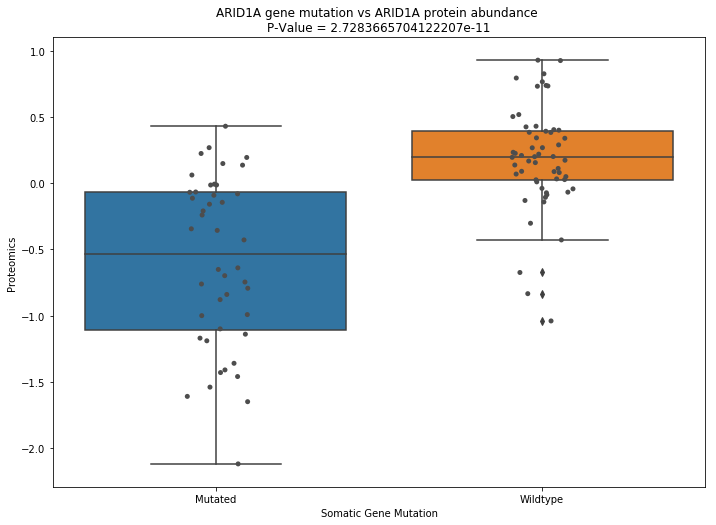

In [8]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
somatic_boxplot = sns.boxplot(data=cross, x="Mutation",y=protein, ax = ax)
somatic_boxplot.set_title("ARID1A gene mutation vs ARID1A protein abundance \nP-Value = " + str(ttest[1]))
somatic_boxplot = sns.stripplot(data=cross, x="Mutation", y=protein,jitter=True, color=".3")
somatic_boxplot.set(xlabel="Somatic Gene Mutation",ylabel="Proteomics")
plt.show()

### Phosphoproteomic difference in ARID1A

In [5]:
sites = phos.columns
p_values = []
site_names = []
protein = 'ARID1A'

pcutoff = 0.05/len(phos.columns)

pattern = re.compile(protein)
isInList = filter(pattern.search, sites)
if next(isInList, None) is not None:
    phosphositesdf = CPTAC.compare_mutations(phos, protein, gene)
    phosphositesdf = phosphositesdf.loc[phosphositesdf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis = 1)
    for site in phosphositesdf.columns:
        if (site is not 'Mutation'):
            sitedf = CPTAC.compare_mutations(phos, site, gene)
            sitedf = sitedf.loc[sitedf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis = 1)
            mutateddf = sitedf.loc[sitedf['Mutation'] != 'Wildtype'].dropna(axis=0)
            wtdf = sitedf.loc[sitedf['Mutation'] == 'Wildtype'].dropna(axis=0)
            ttest = scipy.stats.ttest_ind(mutateddf[site], wtdf[site])
            if ttest[1] < pcutoff:
                p_values.append(ttest[1])
                print(site, ttest[1])
                site_names.append(site)     
                
#We need to remove all 'nan' p-values and their corresponding site names before passing it in for the fdr correction
indexesToRemove=[]

for index in range(0, len(p_values)):
    if np.isnan(p_values[index]):
        indexesToRemove.append(index)

for rem in range( len(indexesToRemove)-1, -1, -1):
    p_values.pop(indexesToRemove[rem])
    site_names.pop(indexesToRemove[rem])

ARID1A-S1184 1.0349980050963608e-07
ARID1A-S1604 1.9926532216398217e-07
ARID1A-S1755 4.012400598928052e-09


/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3157: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Plot these three significant sites:

p_values:  [1.0349980050963608e-07]
site_names:  ['ARID1A-S1184']


[Text(0, 0.5, 'Phosphoproteomics'), Text(0.5, 0, 'Somatic Gene Mutation')]

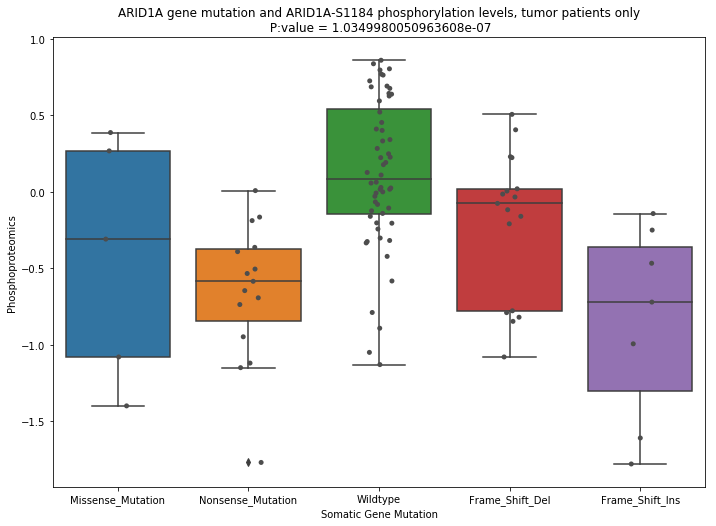

In [13]:
gene = 'ARID1A'

site="ARID1A-S1184"

#Build the dataframe for plotting
genedf = CPTAC.compare_mutations(phos, site, gene)
genedf = genedf.loc[genedf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis = 1)

p_values = []
site_names = []
mutateddf = genedf.loc[genedf['Mutation'] != 'Wildtype'].dropna(axis=0)
wtdf = genedf.loc[genedf['Mutation'] == 'Wildtype'].dropna(axis=0)

ttest = scipy.stats.ttest_ind(mutateddf[site], wtdf[site])
p_values.append(ttest[1])
site_names.append(site)

print("p_values: ", p_values)
print("site_names: ", site_names)

a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
phos_boxplot = sns.boxplot(data=genedf, x="Mutation" ,y=site)
phos_boxplot.set_title(gene + " gene mutation and " + site + " phosphorylation levels, tumor patients only" + "\n P:value = " + str(p_values[0]))     
phos_boxplot = sns.stripplot(data=genedf, x="Mutation", y=site,jitter=True, color=".3")
phos_boxplot.set(xlabel="Somatic Gene Mutation",ylabel="Phosphoproteomics")

[Text(0, 0.5, 'Phosphoproteomics'), Text(0.5, 0, 'Somatic Gene Mutation')]

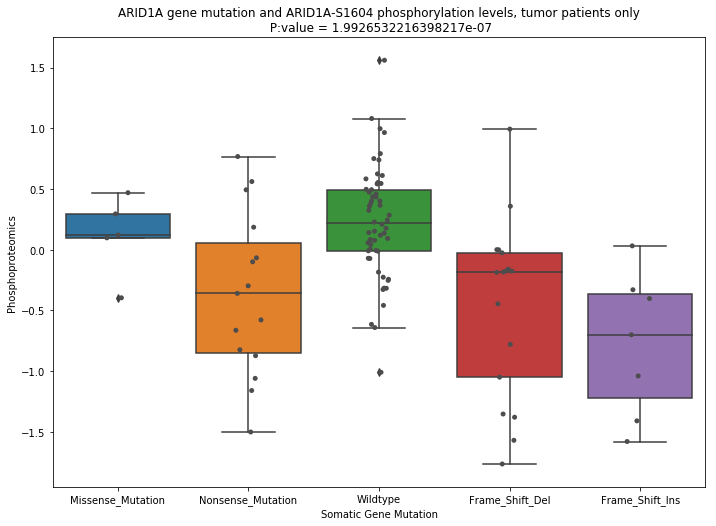

In [16]:
gene = 'ARID1A'

site="ARID1A-S1604"

#Build the dataframe for plotting
genedf = CPTAC.compare_mutations(phos, site, gene)
genedf = genedf.loc[genedf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis = 1)
#print(genedf)

p_values = []
site_names = []
mutateddf = genedf.loc[genedf['Mutation'] != 'Wildtype'].dropna(axis=0)
wtdf = genedf.loc[genedf['Mutation'] == 'Wildtype'].dropna(axis=0)

ttest = scipy.stats.ttest_ind(mutateddf[site], wtdf[site])
p_values.append(ttest[1])
site_names.append(site)

#print("p_values: ", p_values)
#print("site_names: ", site_names)

a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
phos_boxplot = sns.boxplot(data=genedf, x="Mutation" ,y=site)
phos_boxplot.set_title(gene + " gene mutation and " + site + " phosphorylation levels, tumor patients only" + "\n P:value = " + str(p_values[0]))     
phos_boxplot = sns.stripplot(data=genedf, x="Mutation", y=site,jitter=True, color=".3")
phos_boxplot.set(xlabel="Somatic Gene Mutation",ylabel="Phosphoproteomics")

[Text(0, 0.5, 'Phosphoproteomics'), Text(0.5, 0, 'Somatic Gene Mutation')]

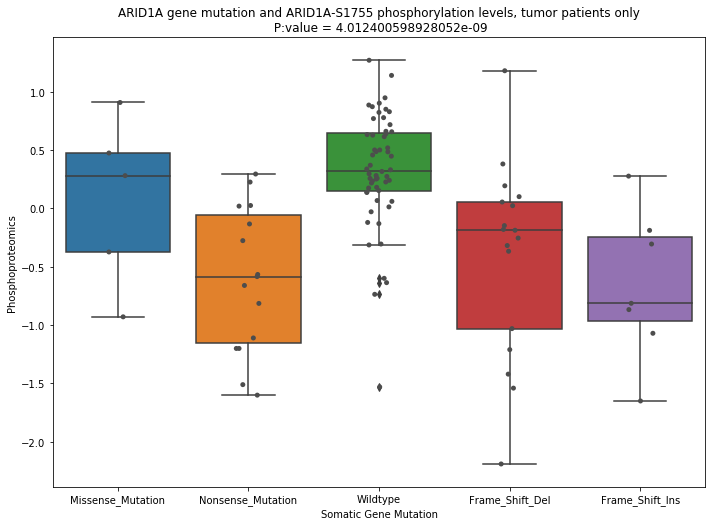

In [15]:

gene = 'ARID1A'

site="ARID1A-S1755"

#Build the dataframe for plotting
genedf = CPTAC.compare_mutations(phos, site, gene)
genedf = genedf.loc[genedf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis = 1)

p_values = []
site_names = []
mutateddf = genedf.loc[genedf['Mutation'] != 'Wildtype'].dropna(axis=0)
wtdf = genedf.loc[genedf['Mutation'] == 'Wildtype'].dropna(axis=0)

ttest = scipy.stats.ttest_ind(mutateddf[site], wtdf[site])
p_values.append(ttest[1])
site_names.append(site)

#print("p_values: ", p_values)
#print("site_names: ", site_names)


#print(genedf)
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
phos_boxplot = sns.boxplot(data=genedf, x="Mutation" ,y=site)
phos_boxplot.set_title(gene + " gene mutation and " + site + " phosphorylation levels, tumor patients only" + "\n P:value = " + str(p_values[0]))     
phos_boxplot = sns.stripplot(data=genedf, x="Mutation", y=site,jitter=True, color=".3")
phos_boxplot.set(xlabel="Somatic Gene Mutation",ylabel="Phosphoproteomics")

## ARID1A Levels in Tumor vs. Regular Patients

In [9]:
proteomics = CPTAC.get_proteomics()
cancerProteomics = proteomics[:100]
regularProteomics = proteomics[100:]

cancerProteomics = cancerProteomics['ARID1A']
regularProteomics = regularProteomics['ARID1A']
ARID1A_proteomics = proteomics['ARID1A']

#print(cancerProteomics[0])
#print("\n", cancerProteomics)

ttest = scipy.stats.ttest_ind(cancerProteomics, regularProteomics)
p_values = list()
p_values.append(ttest[1])

print(p_values)

[0.0692887528650658]


[Text(0, 0.5, 'ARID1A Abundance'), Text(0.5, 0, 'patient type')]

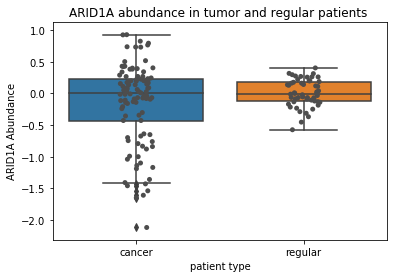

In [10]:
df = pd.DataFrame()

type = list()
for i in range(0, len(ARID1A_proteomics)):
    if i < 101:
        type.append('cancer')
    else:
        type.append('regular')
        
        
df['ARID1A'] = ARID1A_proteomics
df['type'] = type

boxplot = sns.boxplot(data= df, x="type" ,y="ARID1A")
boxplot.set_title(gene + " abundance in tumor and regular patients ")     
boxplot = sns.stripplot(data=df, x="type", y="ARID1A",jitter=True, color=".3")
boxplot.set(xlabel="patient type",ylabel="ARID1A Abundance")